In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import (streaming_classifier,
                                   one_pronged_smoothing_classifier,
                                   zeroes_classifier,
                                   max_min_range_classifier,
                                   catch22_knn_classifier,
                                   )


In [5]:

waves, labels, samprate = load_training_data(path = "/Users/darap/Documents/School/University/2021, Sem. 1/DATA3888/Aqua10/Datasets/data/",
                       scale_factor= 512/(2**13 - 1),
                       whitelist = ["data"])


dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8']) dict_keys(['data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\notebooks\Classifier\load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [7]:
# Set parameters such that event detection window lands in the middle of the signal

hyp_event_smart_threshold_window = 5
hyp_event_smart_threshold_factor = 5

hyp_detection_buffer_end = 0.6
hyp_detection_buffer_start = 0.2


det_window = 0.6432

window_size = det_window + hyp_detection_buffer_end + hyp_detection_buffer_start

N_loops_over_window = 15

buffer_size = window_size/N_loops_over_window

hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
#print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



classifiers = {"One-pronged": one_pronged_smoothing_classifier,
               "Zeroes classifier": zeroes_classifier,
               "Max-min-range": max_min_range_classifier,
               "KNN classifier": catch22_knn_classifier,
               "Naive Random": lambda x,y: "R" if np.random.rand()<0.5 else "L",
               "Naive Undecided": lambda x,y: "_"
               }

all_classification_times = {}
better_all_classification_times = {}

using_zeroes = False
accs = []
for classifier_label, classifier in classifiers.items():
    print(classifier_label)
    start = time.time()

    if classifier_label == "Zeroes classifier":
        using_zeroes = True
    else:
        using_zeroes = False
    for i, key in enumerate(waves):
        predictions, predictions_timestamps, predictions_storage, times = streaming_classifier(
            waves[key], # Either the array from file (or ser if live = True)
            samprate,
            classifier = classifier, 
            using_zeroes_classifier = using_zeroes,
            plot_zeroes_classifier = False,
            window_size = window_size, # Total detection window [s]
            N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
            hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off end of the window in order to define the middle portion
            hyp_detection_buffer_start = hyp_detection_buffer_start, # seconds - how much time to shave off start of the window in order to define the middle portion
            hyp_event_smart_threshold_window = hyp_event_smart_threshold_window, # The length of the calibration period to define the threshold
            hyp_calibration_statistic_function = np.std, # Function that calculates the calibration statistic
            hyp_test_statistic_function = lambda x: np.max(x) - np.min(x), # Function that calculates the test statistic
            hyp_event_smart_threshold_factor = hyp_event_smart_threshold_factor, # The scale factor of the calibration range that will become the threshold
            hyp_event_history = hyp_consecutive_triggers+1, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
            hyp_consecutive_triggers = hyp_consecutive_triggers, # How many threshold triggers need to occur in a row for an event to be called
            hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
            total_time = None,  # max time. If none, it goes forever!
            plot = False, # Whether to plot the livestream data
            store_events = True, # Whether to return the classification window array for debugging purposes
            store_times = True, # To see how long classification takes
            verbose = False, # lol
            live = False, # Whether we're live
            hyp_timeout = 10,
            timeout = False)

        actuals = "".join(labels[key].label)

        lev_dist = lev(actuals, predictions)
        acc = abs(len(actuals) - lev_dist)/len(actuals)
        #print("Acc:", acc)
        accs.append(acc)

        if classifier_label in better_all_classification_times.keys():
            better_all_classification_times[classifier_label] += times

        else:
            better_all_classification_times[classifier_label] = times
   

        if "times" in all_classification_times.keys():
            all_classification_times["times"].append(times)
            all_classification_times["classifier"].append(classifier_label)
        else:
            all_classification_times["times"] = []
            all_classification_times["classifier"] = []
            all_classification_times["times"].append(times)
            all_classification_times["classifier"].append(classifier_label)
    end = time.time()
    print("time taken: ", end - start)
    print("Accs:", np.mean(accs))
    if classifier_label == "Zeroes classifier":
        zeroes_time = end - start
    elif classifier_label == "Nil classifier":
        nil_time = end - start
        diff = zeroes_time - nil_time
        longer_times = []
        for time1 in better_all_classification_times["Zeroes classifier"]:
            if time1 > 1:
                longer_times.append(time1)
        print("Total sum of bigger times:", (diff - np.sum(longer_times)))
        print("Average of bigger times:", (diff - np.sum(longer_times)) / (len(better_all_classification_times["Zeroes classifier"]) - len(longer_times)))
    
    print("done")

print("total length: ", len(better_all_classification_times["One-pronged"]))
#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



One-pronged
time taken:  0.4798877239227295
Accs: 0.4882331590976453
done
Zeroes classifier
time taken:  2.924316167831421
Accs: 0.4882331590976453
done
Max-min-range
time taken:  1.0750885009765625
Accs: 0.48823315909764536
done
KNN classifier


NameError: name 'catch22' is not defined



 One-pronged
[2001700, 4001100, 1975100, 3328300, 2002400, 3001100, 2000200, 1999100, 1995900, 2000300, 1999100, 2001800, 2000300, 1998400, 1999900, 999900, 1006900, 993900, 2000200, 1995200, 1999000, 1001300, 979500, 2002400, 980400, 2000300, 1000900, 2002000, 2001000, 1978200, 2979900, 3400600, 1978600, 2962800, 1939600, 2522900, 2998300, 2996600, 2995900, 8003100, 6004700, 2997400, 4000800, 1998600, 2000100, 1999800, 1002100, 1986900, 1000100, 995700, 1989300, 2000500, 2001000, 1979200, 2000100, 1000100, 1001700, 989300, 2000700, 2002400, 2000700, 1998300, 3003200, 2980800, 3007100, 2001700, 2000500, 2000200, 2999700, 1993600, 1982600, 1999600, 1999200, 979400, 2001700, 2001600, 2015300, 998800, 2000600, 2005000, 1001100, 2000400, 997600, 998400, 1000500, 999900, 2014300, 1998300, 1710500, 2020400, 1979000, 4003000, 2999600, 3002500, 2000600, 1986200, 2003600, 1998100, 2004100, 2999300, 2000400, 2012700] 

102
sum: 216674700
median: 2000250.0
mean:  2124261.7647058824


 Three-pro

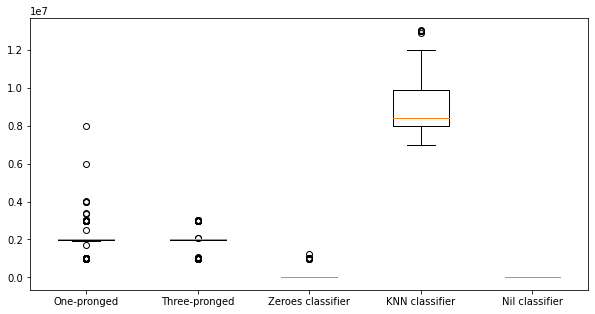

In [13]:
import statistics
plt.figure(figsize=(10, 5))
plt.boxplot(better_all_classification_times.values(), labels = better_all_classification_times.keys())

for key, values in better_all_classification_times.items():
    print("\n\n", key)
    print(values, "\n")
    print(len(values))
    print("sum:", np.sum(values))
    print("median:", statistics.median(values))
    print("mean: ", np.mean(values))
